You can run this notebook in a [live session](https://binder.pangeo.io/v2/gh/pangeo-data/climpred/main?urlpath=lab/tree/docs/source/examples/decadal/verify_dim_implications.ipynb) [<img src="https://mybinder.org/badge_logo.svg" alt='binder badge'>](https://binder.pangeo.io/v2/gh/pangeo-data/climpred/main?urlpath=lab/tree/docs/source/examples/decadal/verify_dim_implications.ipynb) or view it [on Github](https://github.com/pangeo-data/climpred/blob/main/docs/source/examples/decadal/verify_dim_implications.ipynb).

## Implications of `verify(dim)`

This demo demonstrates how setting `dim` in {py:meth}`.PerfectModelEnsemble.verify` and {py:meth}`.HindcastEnsemble.verify` alters the research question and prediction skill obtained, especially for spatial fields.

**What's the purpose of `dim`?**

`dim` is designed the same way as in {py:meth}`xarray.Dataset.mean`. A given metric is calculated over dimension `dim`, i.e. the result does not contain `dim` anymore. `dim` can be a string or list of strings.

**3 ways to calculate aggregated prediction skill**
- Spatially aggregate first, then `verify`
- `verify` on each grid point, then aggregate spatially
- `verify` over spatial, `member` and `init`ialization directly

In [1]:
# linting
%load_ext nb_black
%load_ext lab_black

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import climpred

climpred.set_options(PerfectModel_persistence_from_initialized_lead_0=True)

<IPython.core.display.Javascript object>

### sample spatial initialized ensemble data and nomenclature

We also have some sample output that contains gridded data on MPIOM grid:
- `initialized3d`: The initialized ensemble dataset with
    - `member`s (`1`, ... , `4`) denoted by $m$
    - `init`s (initialization years: `3014`, `3061`, `3175`, `3237`) denoted by $i$
    - `lead` years (`1`, ..., `5`) denoted by $l$.
    - `x` and `j` (think as longitude and latitude): spatial dimensions denotes by $s$.

- `control3d`: The control dataset spanning over `time` (`3000`, ..., `3049`) [not used here].

In {py:meth}`.PerfectModelEnsemble.verify`, we calculate a $metric$ on $data(s,i,m,l)$ containing spatial dimensions $s$ and ensemble dimension $i,m,l$ over dimensions $dim$ denoted by $metric(data(s,i,m,l), dim)$.

In [3]:
# Sea surface temperature
initialized3d = climpred.tutorial.load_dataset("MPI-PM-DP-3D")
control3d = climpred.tutorial.load_dataset("MPI-control-3D")
v = "tos"
initialized3d["lead"].attrs = {"units": "years"}

<IPython.core.display.Javascript object>

In [4]:
# Create climpred PerfectModelEnsemble object.
pm = (
    climpred.PerfectModelEnsemble(initialized3d).add_control(control3d)
    # .generate_uninitialized() # needed for uninitialized in reference
)

/Users/aaron.spring/Coding/climpred/climpred/utils.py:195: UserWarning: Assuming annual resolution starting Jan 1st due to numeric inits. Please change ``init`` to a datetime if it is another resolution. We recommend using xr.CFTimeIndex as ``init``, see https://climpred.readthedocs.io/en/stable/setting-up-data.html.
  warnings.warn(
/Users/aaron.spring/mambaforge/envs/climpred-dev/lib/python3.10/site-packages/xarray/coding/times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/Users/aaron.spring/Coding/climpred/climpred/utils.py:195: UserWarning: Assuming annual resolution starting Jan 1st due to numeric inits. Please change ``init`` to a datetime if it is another resolution. We recommend using xr.CFTimeIndex as ``init``, see https://climpred.readthedocs.io/en/stable/setting-up-data.html.
  warnings.warn(
/Users/aaron.spring/mambaforge/envs/climpred-dev/lib/python3.10/site-packages/xar

<IPython.core.display.Javascript object>

#### subselecting North Atlantic

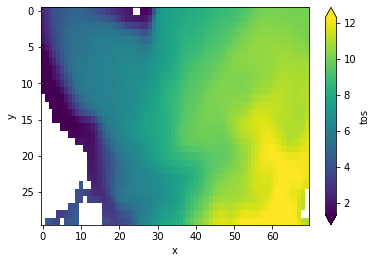

<IPython.core.display.Javascript object>

In [5]:
pm = pm.isel(x=slice(80, 150), y=slice(40, 70))
pm.get_initialized().mean(["lead", "member", "init"])[v].plot(
    yincrease=False, robust=True
)

In [6]:
verify_kwargs = dict(
    metric="pearson_r",  # 'rmse'
    comparison="m2m",
    reference=["persistence", "climatology"],  # "uninitialized",
    skipna=True,
)
dim = ["init", "member"]
spatial_dims = ["x", "y"]

<IPython.core.display.Javascript object>

Here, we use the anomaly correlation coefficient {py:func}`.climpred.metrics._pearson_r`. Also try root-mean-squared-error {py:func}`.climpred.metrics._rmse`.

### Spatial aggregate first, then `verify`

Here, we first average the raw ensemble data over the `spatial_dims`, i.e. creating North Atlantic averaged SST timeseries. On this timeseries, we calculate the prediction skill with {py:meth}`.PerfectModelEnsemble.verify`.

$skill(l) = metric(\overline{data(s,i,m,l)}^s, i, m)$

where $\overline{data}^{dim}$ represents the average of $data$ over dimension $dim$

This approach answers the question: "What's the prediction skill of SSTs, which were averaged before over the North Atlantic?"

Used in {cite:t}`Pohlmann2004,Seferian2018,Spring2020`.

<AxesSubplot:title={'center':' '}, xlabel='validity time', ylabel='tos'>

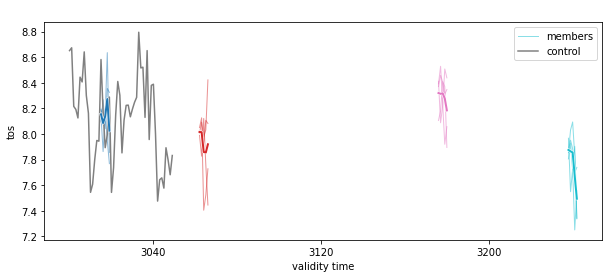

<IPython.core.display.Javascript object>

In [7]:
pm_aggregated = pm.mean(spatial_dims)
# see the NA SST timeseries
pm_aggregated.plot(show_members=True)

/Users/aaron.spring/Coding/climpred/climpred/classes.py:1597: UserWarning: Calculate persistence from lead=1 instead of lead=0 (recommended).
  warnings.warn(


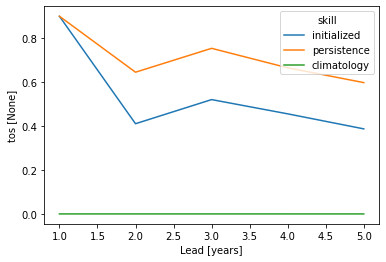

<IPython.core.display.Javascript object>

In [8]:
pm_aggregated_skill = pm_aggregated.verify(dim=dim, **verify_kwargs)
pm_aggregated_skill[v].plot(hue="skill")

### `verify` on each grid point, then aggregate

Here, we first calculate prediction skill with {py:meth}`.PerfectModelEnsemble.verify` and then average the SST skill over the North Atlantic region.

$skill(l) = \overline{metric(data(s,i,m,l), i, m)}^s$

This approach answers the question: "What's the prediction skill of North Altantic SST grid points averaged afterwards?"

Used in {cite:t}`Frolicher2020`.

/Users/aaron.spring/Coding/climpred/climpred/classes.py:1597: UserWarning: Calculate persistence from lead=1 instead of lead=0 (recommended).
  warnings.warn(


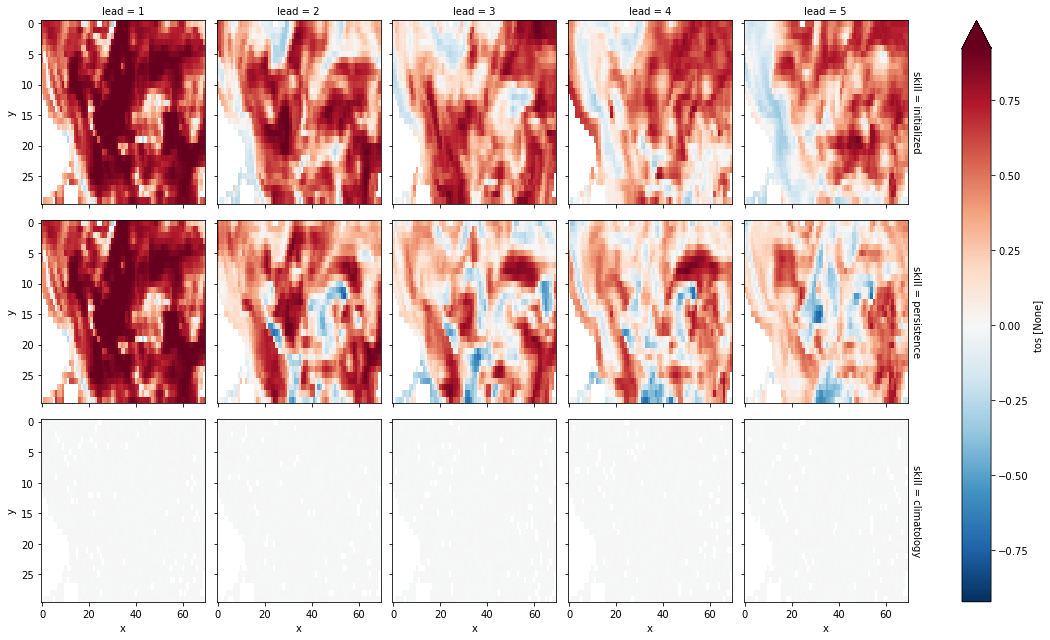

<IPython.core.display.Javascript object>

In [9]:
grid_point_skill = pm.verify(dim=dim, **verify_kwargs)
grid_point_skill[v].plot(col="lead", row="skill", robust=True, yincrease=False)

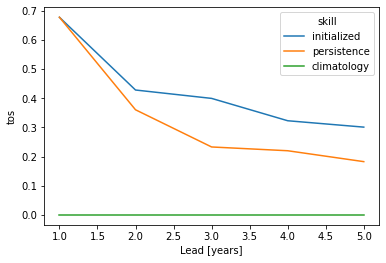

<IPython.core.display.Javascript object>

In [10]:
grid_point_skill_aggregated = grid_point_skill.mean(spatial_dims)
grid_point_skill_aggregated[v].plot(hue="skill")
plt.show()

### `verify` over each grid point, `member` and `init`ialization directly

Here, we directly calculate prediction skill with {py:meth}`.PerfectModelEnsemble.verify` over `spatial_dims`, `member` and `init`.

$skill(l) = metric(data(s,i,m,l), s, i, m)$

This approach answers the question: What's the prediction skill of the North Atlantic SST pattern (calculated over all `member`s and `init`s)?

Used in {cite:t}`Becker2014,Fransner2020`.

/Users/aaron.spring/Coding/climpred/climpred/classes.py:1597: UserWarning: Calculate persistence from lead=1 instead of lead=0 (recommended).
  warnings.warn(


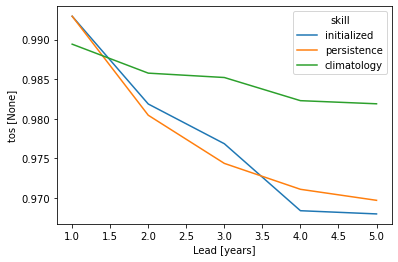

<IPython.core.display.Javascript object>

In [11]:
skill_all_at_once = pm.verify(dim=dim + spatial_dims, **verify_kwargs)
skill_all_at_once[v].plot(hue="skill")
plt.show()

This approach yields very similar results to first calculating prediction skill over the `spatial_dims`, i.e. calculating a pattern correlation and then doing a mean over ensemble dimensions `member` and `init`.

$skill(l) = \overline{metric(data(s,i,m,l), s)}^{i,m}$

/Users/aaron.spring/Coding/climpred/climpred/classes.py:1597: UserWarning: Calculate persistence from lead=1 instead of lead=0 (recommended).
  warnings.warn(


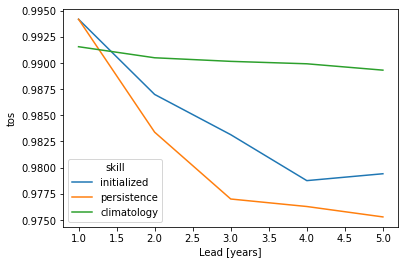

<IPython.core.display.Javascript object>

In [12]:
skill_spatial_then_ensemble_mean = pm.verify(dim=spatial_dims, **verify_kwargs).mean(
    dim
)
skill_spatial_then_ensemble_mean[v].plot(hue="skill")
plt.show()

### Summary

The three approaches yield very different results based on the `dim` keyword. Make you choose `dim` according to the question you want to answer. And always compare your `initialized` skill to the `reference` skills, which also heavily depend on `dim`. The small details matter a lot!

In [13]:
skills = xr.concat(
    [pm_aggregated_skill, grid_point_skill_aggregated, skill_all_at_once], "method"
).assign_coords(method=["skill of aggregated", "grid skill aggregated", "all directly"])

<IPython.core.display.Javascript object>

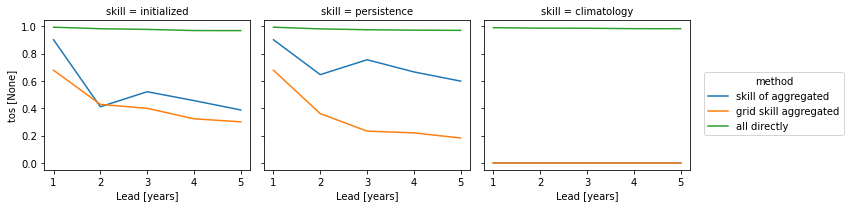

<IPython.core.display.Javascript object>

In [14]:
skills[v].plot(hue="method", col="skill")

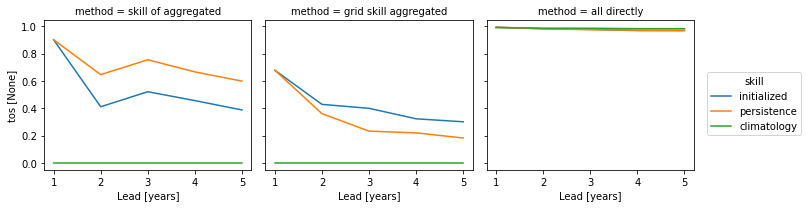

<IPython.core.display.Javascript object>

In [15]:
skills[v].plot(col="method", hue="skill")

#### References

```{eval-rst}
.. bibliography::
   :filter: docname in docnames
```